In [1]:
import random
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from sklearn.metrics import mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller, kpss

warnings.filterwarnings("ignore")

In [2]:
def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)


seed_everything()

# Загрузка и первичный анализ данных

__Посмотрим на данные.__

Работать мы будем  с датасетом Tourism, который содержит данные о количестве туристов в разных странах — https://zenodo.org/records/4656096.

In [3]:
df = pd.read_csv('monash_tourism_monthly.csv')
df = df.rename(columns={'timestamp': 'date', 'target': 'value'})
df.head()

,id,date,value
0,T000000,1979-01-31,1149.8700
1,T000000,1979-02-28,1053.8002
2,T000000,1979-03-31,1388.8798
3,T000000,1979-04-30,1783.3702
4,T000000,1979-05-31,1921.0252


In [4]:
fig = go.Figure()
seed_everything()
random_ids = np.random.choice(df["id"].unique(), 10, replace=False)

for i in random_ids:
    fig.add_trace(
        go.Scatter(x=df[df["id"] == i]["date"], y=df[df["id"] == i]["value"], name=str(i))
    )
fig.update_layout(title="Tourism Monthly Dataset", xaxis_title="Date", yaxis_title="Value")
fig.show()

In [5]:
HORIZON = 36

random_series = "T000033"  # Вот так захотелось :)
random_series = df[df["id"] == random_series]

# Разделим данные на обучающую и тестовую выборки
train_size = len(random_series) - HORIZON
train_split_date = np.sort(random_series["date"])[train_size]

train_data = random_series[random_series["date"] < train_split_date]
test_data = random_series[random_series["date"] >= train_split_date]

__`Вопрос:`__ __Почему при анализе временных рядов мы не можем просто использовать рандомное разбиение на train и test?__

In [6]:
fig = go.Figure()
fig.add_trace(
    go.Scatter(x=train_data["date"], y=train_data["value"], name="Train", line=dict(color="blue"))
)
fig.add_trace(
    go.Scatter(x=test_data["date"], y=test_data["value"], name="Test", line=dict(color="red"))
)
fig.update_layout(
    title="Train/Test Split", xaxis_title="Date", yaxis_title="Value"
)
fig.show()

__Очевидно, что ряд нестационарный. Посмотрим, что на это скажут статистические тесты.__

## Тесты на стационарность

Рассмотрим два наиболее популярных теста на стационарность:
- Тест Дики-Фуллера (Augmented Dickey-Fuller test) — https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html
- KPSS-тест (Kwiatkowski-Phillips-Schmidt-Shin test) — https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.kpss.html

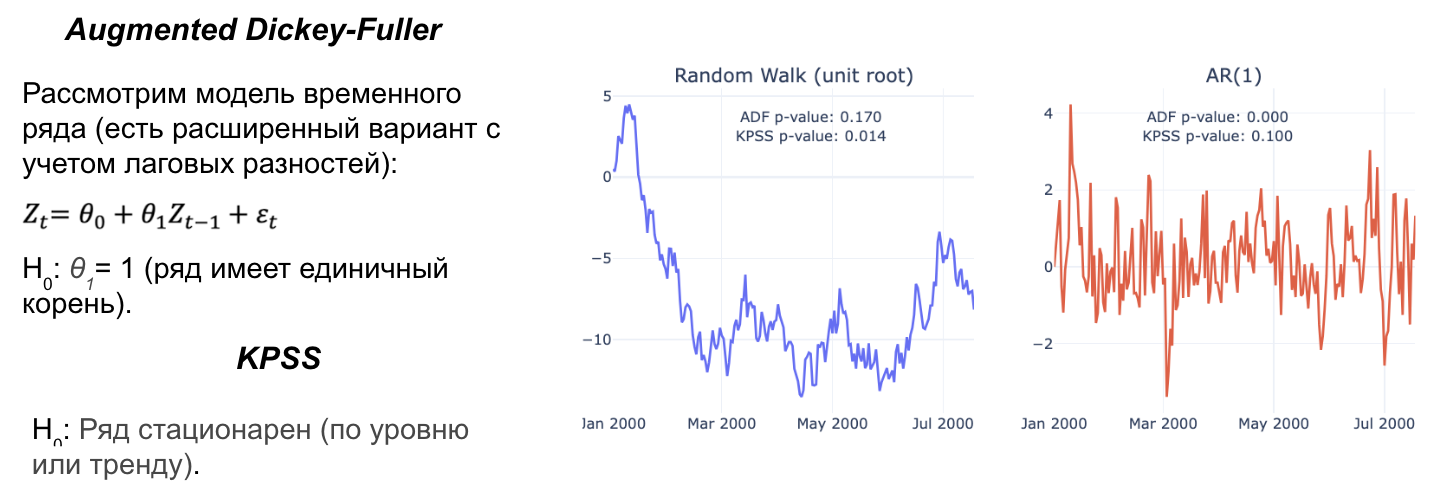

In [7]:
# KPSS test
# H0: временной ряд стационарен
# H1: временной ряд не стационарен
statistic, p_value, lags, critical_values = kpss(train_data["value"])
print(f"KPSS p-value: {p_value}")

# ADF test
# H0: unit root (не стационарен)
# H1: no unit root (стационарен)
statistic, p_value, usedlag, _, critical_values, icbest = adfuller(train_data["value"])
print(f"ADF p-value: {p_value}")

KPSS p-value: 0.01
ADF p-value: 0.9515404931313128


__`Вопрос:`__ __Как интерпретировать результаты этих тестов?__

## ACF, PACF, SARIMA

Теперь подойдем к ряду с другой стороны — через графики автокорреляций. Построим на их основе SARIMA модель.

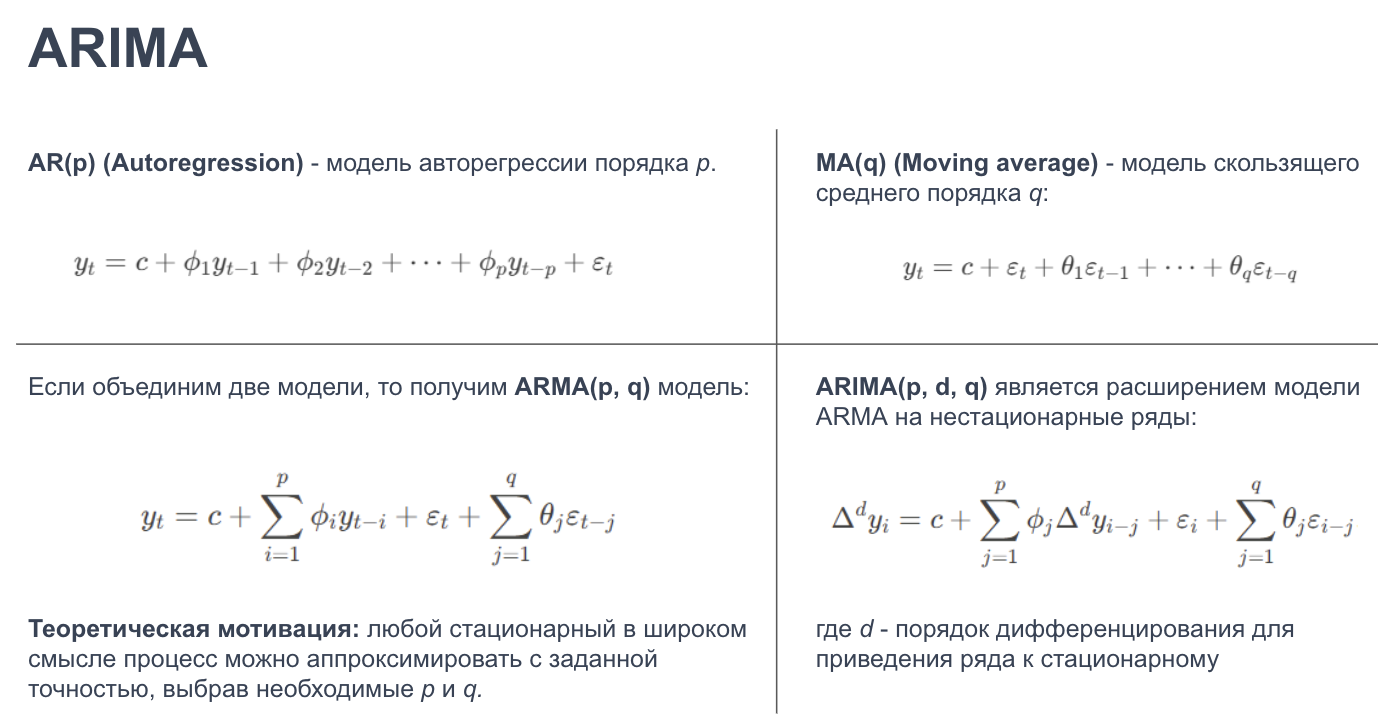

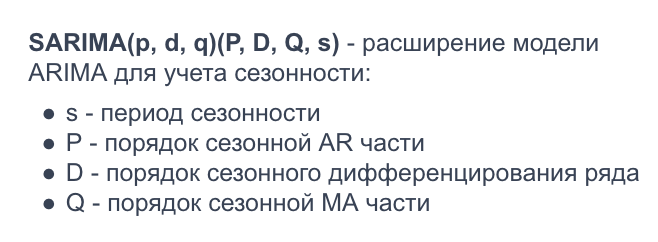

Ручной подбор гиперпараметров для подобных моделей — ручной и итеративный процесс, который плохо масштабируется на ситуации, когда нужно прогнозировать сотни и даже тысячи временных рядов одновременно. Давайте один раз попробуем это сделать, чтобы понять, насколько это неприятная процедура.

Правила построения SARIMA модели хорошо описаны в этой статье: https://people.duke.edu/~rnau/arimrule.html

Так как сезонность мультипликативная, то попробуем логарифмировать ряд.

In [8]:
log_train_data = np.log(train_data["value"].astype("float"))
log_test_data = np.log(test_data["value"].astype("float"))

fig = go.Figure()
fig.add_trace(
    go.Scatter(x=train_data["date"], y=log_train_data, name="Log Train", line=dict(color="blue"))
)
fig.add_trace(
    go.Scatter(x=test_data["date"], y=log_test_data, name="Log Test", line=dict(color="red"))
)
fig.update_layout(
    title="Log Train/Test Split", xaxis_title="Date", yaxis_title="Value"
)
fig.show()

Построим графики ACF и PACF.

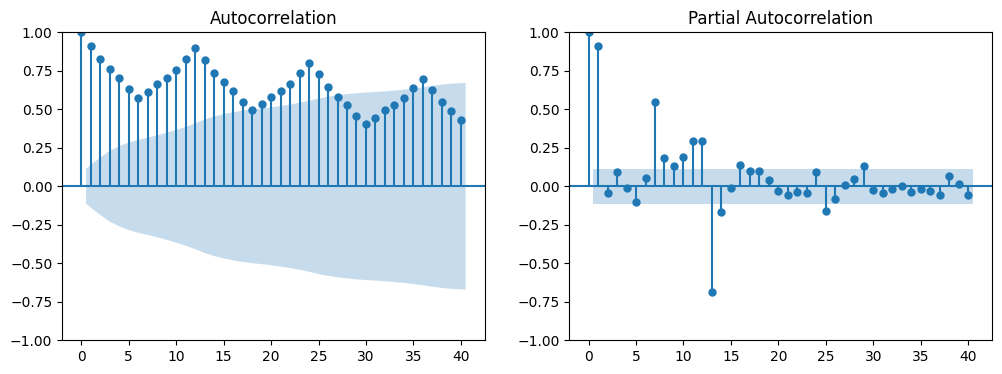

In [9]:
# ACF и PACF
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(log_train_data, lags=40, ax=ax[0])
plot_pacf(log_train_data, lags=40, ax=ax[1])
plt.show()

- По первому правилу, если ряд имеет положительные автокорреляции до большого числа лагов, то, вероятно, требуется более высокий порядок дифференцирования.
- По двенадцатому правилу, если ряд имеет ярко выраженный и устойчивый сезонный паттерн, то необходимо использовать порядок сезонного дифференцирования.

Никогда не применяйте более одного порядка сезонного дифференцирования или более двух порядков общего дифференцирования (сезонного + несезонного).

Проведем сезонное дифференцирование и снова посмотрим на графики ACF и PACF.

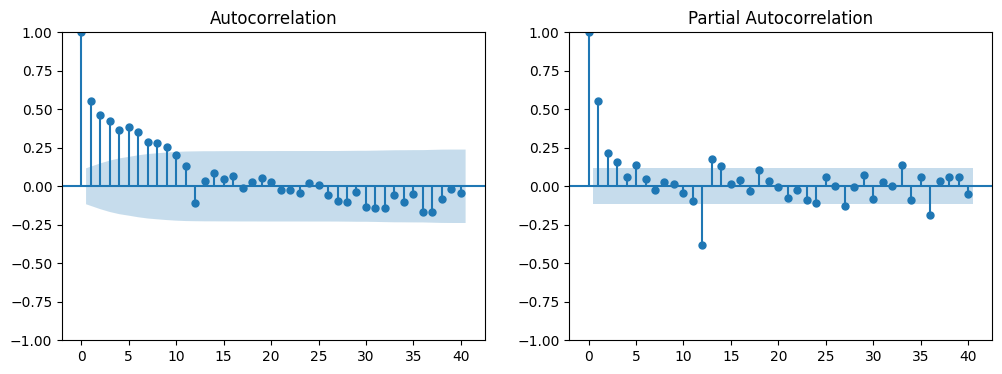

In [10]:
PERIOD = 12

# ACF и PACF после сезонного дифференцирования
diff_seas_series = log_train_data.diff(PERIOD).dropna()

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(diff_seas_series, lags=40, ax=ax[0])
plot_pacf(diff_seas_series, lags=40, ax=ax[1])
plt.show()

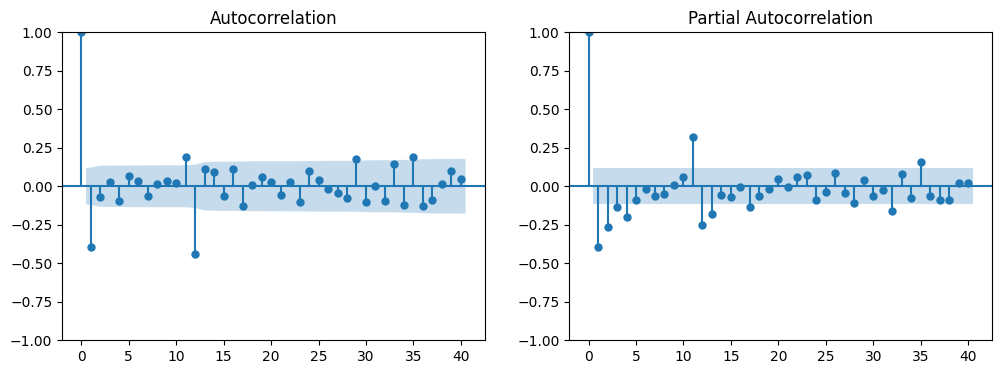

In [11]:
# ACF и PACF после сезонного и обычного дифференцирования
diff__diff_series = diff_seas_series.diff().dropna()

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(diff__diff_series, lags=40, ax=ax[0])
plot_pacf(diff__diff_series, lags=40, ax=ax[1])
plt.show()

- По седьмому правилу, лаг, после которого ACF обрывается, указывает на требуемое количество MA членов.
- По тренадцатому правилу, если автокорреляция дифференцированного ряда отрицательна на лаге s, то надо добавить SMA член в модель.

__Итого наш первый кандидат: SARIMA(0, 1, 1)(0, 1, 1, 12)__

                                     SARIMAX Results                                      
Dep. Variable:                              value   No. Observations:                  294
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                 264.783
Date:                            Mon, 01 Dec 2025   AIC                           -523.565
Time:                                    12:58:01   BIC                           -512.804
Sample:                                         0   HQIC                          -519.243
                                            - 294                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6337      0.048    -13.247      0.000      -0.727      -0.540
ma.S.L12      -0.6616      0.044   

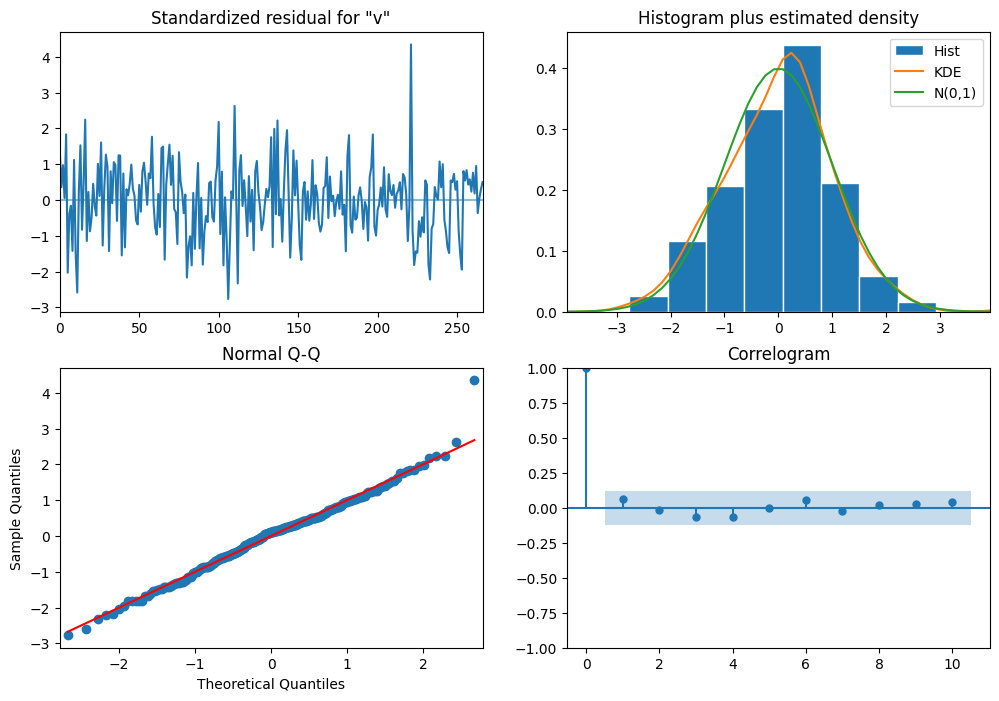

In [12]:
# SARIMA(0, 1, 1)(0, 1, 1, 12) на log ряде
model = SARIMAX(
    log_train_data,
    order=(0, 1, 1),
    seasonal_order=(0, 1, 1, PERIOD),
    enforce_stationarity=False,
    enforce_invertibility=False,
)
model_fit = model.fit(disp=False)
print(model_fit.summary())

model_fit.plot_diagnostics(figsize=(12, 8))
plt.show()

In [13]:
predicted_mean = model_fit.get_forecast(steps=HORIZON).predicted_mean.reset_index(drop=True)
predicted_mean = np.exp(predicted_mean)

predictions = pd.DataFrame({"date": test_data["date"], "value": predicted_mean.values})
fig = go.Figure()
fig.add_trace(
    go.Scatter(x=train_data["date"], y=train_data["value"], name="Train", line=dict(color="blue"))
)
fig.add_trace(
    go.Scatter(x=test_data["date"], y=test_data["value"], name="Test", line=dict(color="red"))
)
fig.add_trace(
    go.Scatter(
        x=predictions["date"], y=predictions["value"], name="Predictions", line=dict(color="green")
    )
)
fig.update_layout(
    title="Train/Test Split with Predictions", xaxis_title="Date", yaxis_title="Value"
)
fig.show()

mae = mean_absolute_error(test_data["value"], predictions["value"])
print(f"MAE: {mae}")

MAE: 2200.7121350681837


Обычно говорят, что остатки модели (любой, не только SARIMA) должны быть стационарными и не иметь автокорреляций. Тогда считается, что мы сделали все, что могли, и осталась только компонента шума.

Информацию об остатках можно получить из `model_fit.plot_diagnostics()`, а также из дополнительных тестов.

Давайте проверим, что остатки являются стационарными и представляют собой «белый шум» без автокорреляции с помощью уже знакомых тестов ADF/KPSS и теста на автокорреляцию Льюнг–Бокса — https://www.statsmodels.org/dev/generated/statsmodels.stats.diagnostic.acorr_ljungbox.html

In [14]:
# H0: остатки стационарны
residuals = model_fit.resid
statistic, p_value, lags, critical_values = kpss(residuals)
print(f"KPSS p-value: {p_value}")

# H0: остатки не стационарны
statistic, p_value, usedlag, _, critical_values, icbest = adfuller(residuals)
print(f"ADF p-value: {p_value}")

# H0: автокорреляция отсутствует
lb_test = acorr_ljungbox(residuals, lags=[10, 12], return_df=True)
print(lb_test)

KPSS p-value: 0.1
ADF p-value: 0.0
      lb_stat     lb_pvalue
10   2.426552  9.919033e-01
12  70.834675  2.234898e-10


Для 10-го лага H0 не отвергаем, а вот для 12-го лага H0 отвергается — возможно, мы не до конца учли сезонность и остатки все еще содержат сигнал, который можно вытащить.

Но все равно по прогнозам кажется, что получилось неплохо. Попробуйте поиграться с гиперпараметрами и посмотрите, можно ли получить модель с меньшей ошибкой.

## Econometrics: baselines & AutoARIMA using statsforecast

Как мы уже проговорили, ручной подбор гиперпараметров для SARIMA модели — это долго. А что, если рядов много?

Давайте вернем исходную постановку задачи: у нас есть много временных рядов, и мы хотим их предсказать. Воспользуемся библиотекой statsforecast, которая позволяет автоматизировать подбор гиперпараметров для SARIMA, ETS и Theta и других статистических моделей.

In [15]:
HORIZON = 36

train_df = []
test_targets = []

for current_id in df["id"].unique():
    current_df = df[df["id"] == current_id]
    # |--------------------- TRAIN_DF  ---------|------ TEST_TARGETS ------|
    # |----------- from start to (-horizon) | from (-horizon) to (end) |
    train_df.append(current_df.iloc[:- HORIZON])
    test_targets.append(current_df.iloc[-HORIZON:])

train_df = pd.concat(train_df)
test_targets = pd.concat(test_targets)

# Здесь нам не нужна валидация — сразу на всем обучаемся и предсказываем test_targets
train_df = train_df.sort_values(["id", "date"])

# В библиотеке требуются определенный формат колонок
train_df = train_df.rename(columns={
    "id": "unique_id",
    "value": "y",
    "date": "ds",
})
train_df["ds"] = pd.to_datetime(train_df["ds"], format="%Y-%m-%d")
train_df["y"] = train_df["y"].astype("float")

print(f"Train shape: {train_df.shape}")
print(f"Test targets shape: {test_targets.shape}")

print(f"Number of series in train set: {train_df['unique_id'].nunique()}")
print(f"Number of series in test targets set: {test_targets['id'].nunique()}")

Train shape: (96104, 3)
Test targets shape: (13176, 3)
Number of series in train set: 366
Number of series in test targets set: 366


In [16]:
from statsforecast import models
from statsforecast import StatsForecast

In [17]:
def analyze_predictions(train_df, test_targets, current_pred, last_points=50):
    """
    Функция для анализа предсказаний модели.
    Вычисляет MAE для всех данных, а также для случайно выбранных id рисует графики
    предсказаний и истинных значений.

    Args:
        train_df: Обучающая выборка.
        test_targets: Целевые значения для тестовой выборки.
        current_pred: Предсказания модели.
        last_points: Количество последних точек в тренировочной выборке для отображения на графиках.

    """
    train_df = train_df.rename(columns={
        "unique_id": "id",
        "y": "value",
        "ds": "date",
    })

    num_ids = 10
    last_points = 50

    colors = [
        "blue", "green", "orange", "purple", "brown",
        "cyan", "magenta", "olive", "teal", "grey",
    ]

    seed_everything()
    random_ids = np.random.choice(test_targets["id"].unique(), num_ids, replace=False)

    random_mae = mean_absolute_error(
        test_targets.loc[test_targets["id"].isin(random_ids), "value"],
        current_pred.loc[current_pred["id"].isin(random_ids), "value"],
    )
    print(f"random {num_ids} mae: {random_mae}")

    fig = go.Figure()

    for i, _id in enumerate(random_ids):
        color = colors[i % len(colors)]

        train_series = train_df[train_df["id"] == _id]
        train_series = train_series.iloc[-min(len(train_series), last_points):]
        train_values = train_series["value"].tolist()
        n_train = len(train_values)

        test_targets_series = test_targets[test_targets["id"] == _id]
        target_values = test_targets_series["value"].tolist()
        n_test = len(target_values)

        preds_series = current_pred[current_pred["id"] == _id]
        preds_values = preds_series["value"].tolist()

        x_train = np.arange(-n_train, 0)
        x_test = np.arange(0, n_test)
        x_pred = np.arange(0, n_test)

        fig.add_trace(go.Scatter(
            x=x_train,
            y=train_values,
            mode="lines",
            name=f"id {_id} train",
            line=dict(color=color)
        ))

        fig.add_trace(go.Scatter(
            x=x_test,
            y=target_values,
            mode="lines",
            name=f"id {_id} true",
            line=dict(color=color)
        ))

        fig.add_trace(go.Scatter(
            x=x_pred,
            y=preds_values,
            mode="lines",
            name=f"id {_id} pred",
            line=dict(color=color, dash="dash")
        ))

    fig.add_shape(dict(
        type="line",
        x0=0,
        y0=0,
        x1=0,
        y1=1,
        xref="x",
        yref="paper",
        line=dict(color="red", width=4)
    ))

    fig.update_layout(
        title="Predictions vs True Values",
        xaxis_title="Date",
        yaxis_title="Values"
    )

    fig.show()

In [18]:
# Инициализируем модель
sf = StatsForecast(
    models=[
        models.SeasonalNaive(season_length=12),
        models.Naive(),
        models.AutoARIMA(season_length=12),
    ],
    freq="MS",  # freq — "месяц start"
    n_jobs=-1,
    verbose=True,
)

In [19]:
# ОСТОРОЖНО: все 366 рядов считаются около 15 минут.
# Поэтому на семинаре лучше взять подвыборку рядов, для которых мы и так рисуем графики
seed_everything()
random_ids = np.random.choice(df["id"].unique(), 10, replace=False)

forecasts_df = sf.forecast(df=train_df.loc[train_df["unique_id"].isin(random_ids)], h=HORIZON)
current_pred = forecasts_df[["unique_id", "ds", "SeasonalNaive", "Naive", "AutoARIMA"]].copy()

Forecast:   0%|          | 0/10 [Elapsed: 00:00]

/Users/elineii/miniconda3/envs/ml_base/lib/python3.12/site-packages/fs/__init__.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__("pkg_resources").declare_namespace(__name__)  # type: ignore
/Users/elineii/miniconda3/envs/ml_base/lib/python3.12/site-packages/fs/__init__.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__("pkg_resources").declare_namespace(__name__)  # type: ignore
/Users/elineii/miniconda3/envs/ml_base/lib/python3.12/site-packages/fs/__init__.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.htm

In [20]:
current_pred

,unique_id,ds,SeasonalNaive,Naive,AutoARIMA
0,T000015,2004-01-01,13421.5,14207.4,13408.163267
1,T000015,2004-02-01,13421.5,14207.4,12627.759304
2,T000015,2004-03-01,12632.0,14207.4,12948.222120
3,T000015,2004-04-01,3789.6,14207.4,10575.633438
4,T000015,2004-05-01,3158.0,14207.4,10219.404509
...,...,...,...,...,...
355,T000310,2007-05-01,288.0,300.0,394.368385
356,T000310,2007-06-01,384.0,300.0,485.616297
357,T000310,2007-07-01,700.0,300.0,730.267560
358,T000310,2007-08-01,484.0,300.0,551.206418


In [21]:
current_pred = current_pred.rename(columns={
    "unique_id": "id",
    "ds": "date",
})

current_pred_seas_naive = current_pred[["id", "date", "SeasonalNaive"]].rename(columns={"SeasonalNaive": "value"})
current_pred_naive = current_pred[["id", "date", "Naive"]].rename(columns={"Naive": "value"})
current_pred_arima = current_pred[["id", "date", "AutoARIMA"]].rename(columns={"AutoARIMA": "value"})

__Naive__

In [22]:
analyze_predictions(train_df, test_targets, current_pred_naive, last_points=50)

random 10 mae: 3070.4910277777776


__SeasonalNaive__

In [23]:
analyze_predictions(train_df, test_targets, current_pred_seas_naive, last_points=50)

random 10 mae: 2211.820083333333


__AutoARIMA__

In [24]:
analyze_predictions(train_df, test_targets, current_pred_arima, last_points=50)

random 10 mae: 1549.159219307705


__`Упражнение:`__

__Можно поиграться с графиками и сидами и посмотреть, есть ли такие ряды, которые лучше предсказываются с помощью наивных моделей, а не с помощью AutoARIMA.__